# Параметры пайплайна (изменяйте здесь)

In [1]:
from dataclasses import dataclass, field

@dataclass
class Config:
    dataset_path: str = "./synthetic_ml_dataset.csv"  # path where to find whole dataset
    data_path: str = "artifacts/data/"  # where to store train, val, test splits
    models_path: str = "artifacts/models/"  # where to store models and preprocessors etc
    features_path: str = "artifacts/features/"  # where to store artifacts from feature selection
    img_path: str = "artifacts/img/"  # where to store graphs etc
    metrics_path: str = "artifacts/metrics/"  # where to store metrics
    task: str = "binary_classification"  # binary classification only notebook
    metric_to_optimize: str = "average_precision"  # roc_auc, etc
    target_column: str = "target"  # name for the target columns
    test_size: float = 0.2  # size of each val and test set (0.2 means that train size will be 0.6 from the original shape)
    stratify: list = field(default_factory=lambda: ['target'])  # list of columns to stratify on
    random_state: int = 42
    n_trials: int = 100  # total number of trials, 2 ** num_hyperparameters + warmup ~20%
    p_warmup: int = 20  # % of trials for random search
    boruta_iterations: int = 50
    log_dir: str = 'log'
    optimizer_name: str = 'optuna'

config = Config()

# Импорты

In [2]:
from abc import ABC, abstractmethod
import os

import logging
import optuna
from datetime import datetime
import joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve, auc, precision_recall_curve
import shap

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from BorutaShap import BorutaShap

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/Users/romansafronenkov/Documents/Projects/uplift/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Настройка логирования

In [3]:
os.makedirs(config.log_dir, exist_ok=True)
os.makedirs(f'{config.log_dir}/{config.optimizer_name}', exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
main_log_file = f'{config.log_dir}/ml_pipeline_{timestamp}.log'

# Основное логирование
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(main_log_file),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)
logger.info("ML Pipeline Started")

# Логирование Optuna
optuna.logging.enable_propagation()
optuna.logging.disable_default_handler()

2026-02-11 15:46:50,999 - __main__ - INFO - ML Pipeline Started


In [4]:
os.makedirs(config.models_path, exist_ok=True)
os.makedirs(config.features_path, exist_ok=True)
os.makedirs(config.img_path, exist_ok=True)
os.makedirs(config.metrics_path, exist_ok=True)
os.makedirs(config.data_path, exist_ok=True)

# 1. Загрузка данных

In [5]:
class DataLoader:
    """
    Класс для загрузки данных.
    """
    def __init__(self, config, save_splitted=True):
        self.config = config
        self.data = None
        self.X = None
        self.y = None

        self.X_train = None
        self.X_val = None
        self.X_test = None

        self.y_train = None
        self.y_val = None
        self.y_test = None

        self.save_splitted = save_splitted
    
    def load_data(self):
        """
        Загрузите данные из файла.
        Верните self.data (X) и self.target (y).
        Сохраните данные для повторного использования.
        """
        logger.info('Загрузка данных')
        self.data = pd.read_csv(self.config.dataset_path)
        logger.info(f'Data loaded, shape: {self.data.shape}')

        if self.data.duplicated().sum() != 0:
            logger.warning("There are duplicated rows in data! It is better to preprocess data manually before running pipeline")
        
        self.y = self.data[self.config.target_column].copy()
        self.X = self.data.drop(self.config.target_column, axis=1).copy()

        if self.config.task == 'binary_classification':
            logger.info(f'Target stats:\n{self.y.value_counts(normalize=True)}')

    
    def split_data(self):
        """
        Разделите данные на train/val/test.
        Сохраните сплиты в self.X_train, self.X_val, self.X_test и аналогично для y.
        """
        logger.info('Разбиваем данные')
        
        if self.config.stratify:
            whole_data = self.X.copy()
            whole_data[self.config.target_column] = self.y
            stratify = whole_data[self.config.stratify]
        else:
            stratify = None
            
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=(2*self.config.test_size), stratify=stratify, shuffle=True, random_state=self.config.random_state)

        if self.config.stratify:
            whole_data = X_test.copy()
            whole_data[self.config.target_column] = y_test
            stratify = whole_data[self.config.stratify]
        else:
            stratify = None
            
        X_val, X_test, y_val, y_test = train_test_split(
            X_test, y_test, test_size=0.5, stratify=stratify, shuffle=True, random_state=self.config.random_state)

        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.X_test, self.y_test = X_test, y_test

        if self.save_splitted:
            self.X_train.to_csv(self.config.data_path+'X_train.csv', index=False)
            self.y_train.to_csv(self.config.data_path+'y_train.csv', index=False)
            
            self.X_val.to_csv(self.config.data_path+'X_val.csv', index=False)
            self.y_val.to_csv(self.config.data_path+'y_val.csv', index=False)
            
            self.X_test.to_csv(self.config.data_path+'X_test.csv', index=False)
            self.y_test.to_csv(self.config.data_path+'y_test.csv', index=False)

            logger.info(f'Data saved to {self.config.data_path}')
            
        
# Использование
# data_loader = DataLoader(
#     config=config
#     save_splitted=True
# )
# data_loader.load_data()
# data_loader.split_data(TEST_SIZE)

# 2. Предобработка данных

In [6]:
class DataPreprocessor:
    """
    Класс для предобработки данных.
    """
    def __init__(self, config):
        self.config = config
        
        self.dtypes = {}
        self.imputers = {}
        self.cols = {'float': [], 'int': [], 'str': []}
        self.objects_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

        self.float_cols = []
        self.int_cols = []
        self.str_cols = []

    
    def fit_transform(self, X_train, y_train=None):
        """
        Обучите и примените предобработку на train.
        Верните обработанные данные.
        """
        X_train = X_train.copy()
        dtypes = X_train.dtypes
        unique_dtypes = dtypes.unique().tolist()

        # сохраним информацию о типах данных
        for dtype in unique_dtypes:
            self.dtypes[str(dtype)] = dtypes[dtypes == dtype].index.tolist()
        
        for dtype, cols in self.dtypes.items():
            if 'float' in dtype:
                self.cols['float'].extend(cols)
            elif 'int' in dtype:
                self.cols['int'].extend(cols)
            elif 'object' in dtype:
                self.cols['str'].extend(cols)
            else:
                logger.warning(f'Found columns of dtype: {dtype}')

        logger.info('Imputing missing values with constant')
        for dtype in self.cols.keys():
            if dtype in ['float', 'int']:
                fill_value = -10**9
            else:
                fill_value = ''
                
            imputer = SimpleImputer(strategy='constant', fill_value=fill_value)
            X_train.loc[:, self.cols[dtype]] = imputer.fit_transform(X_train.loc[:, self.cols[dtype]])
            self.imputers[dtype] = imputer

        logger.info('Encoding objects with OrdinalEncoder')
        X_train.loc[:, self.cols['str']] = self.objects_encoder.fit_transform(X_train.loc[:, self.cols['str']])
        for col in self.cols['str']:
            X_train[col] = X_train[col].astype(int)
        
        return X_train

    def transform(self, X):
        """
        Примените предобработку к новым данным.
        """
        X = X.copy()
        for dtype in self.cols.keys():
            X.loc[:, self.cols[dtype]] = self.imputers[dtype].transform(X.loc[:, self.cols[dtype]])

        X.loc[:, self.cols['str']] = self.objects_encoder.transform(X.loc[:, self.cols['str']])
        
        for col in self.cols['str']:
            X[col] = X[col].astype(int)
            
        return X

    def save(self):
        joblib.dump(self.__dict__, self.config.models_path+'preprocessor_dict.pkl')
        logger.info(f'Preprocessor dict saved to {self.config.models_path+"preprocessor_dict.pkl"}')

    def load(self):
        self.__dict__ = joblib.load(self.config.models_path+'preprocessor_dict.pkl')
        logger.info(f'Preprocessor dict loaded from {self.config.models_path+"preprocessor_dict.pkl"}')
        

# preprocessor = DataPreprocessor()
# X_train_preproc = preprocessor.fit_transform(data_loader.X_train)
# X_val_preproc = preprocessor.transform(data_loader.X_val)
# X_test_preproc = preprocessor.transform(data_loader.X_test)

# preprocessor.save()
# preprocessor.load()

# 3. Отбор признаков

In [7]:
class BaseFeatureSelector(ABC):
    def __init__(self, n_folds=5, random_state=None):
        self.n_folds = n_folds
        self.importances = None
        self.random_state = random_state

    def fit(self, x: np.ndarray, y: np.ndarray, columns: list, **importances_kwargs):
        # TODO: добавить стратификацию по выбранным колонкам
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)  # можно менять число фолдов и прочие параметры

        self.importances = pd.DataFrame({'feature': columns})

        for i, (train_index, val_index) in enumerate(skf.split(x, y)):
            x_train, y_train = x[train_index], y[train_index]
            x_val, y_val = x[val_index], y[val_index]

            model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100, random_state=self.random_state)
            model.fit(x_train, y_train, eval_set=(x_val, y_val))

            imp = self._get_importances_from_model(model, x_val, y_val, **importances_kwargs)

            self.importances[f'importance_{i}'] = imp

    def get_selected_features(self, threshold):
        assert self.importances is not None, 'Сначала нужно обучить, вызвав метод fit'

        # сделаем отдельно для 0 итерации
        imps = self.importances.loc[:, ['feature', 'importance_0']].sort_values('importance_0', ascending=False)  # выберем важности признаков с 0 итерации
        imps['importance_0'] /= imps['importance_0'].sum()
        imps['cumsum'] = imps['importance_0'].cumsum()  # так как мы их отнормировали, может посчитать кумулятивную сумму
        features = imps.loc[imps['cumsum'] <= threshold, 'feature'].tolist()  # возьмем только те признаки, которые по кумулятивной сумме удовлетворяют
        
        best_features = set(features)  # сделаем множество
        for i in range(1, self.n_folds):
            imps = self.importances.loc[:, ['feature', f'importance_{i}']].sort_values(f'importance_{i}', ascending=False)
            imps[f'importance_{i}'] /= imps[f'importance_{i}'].sum()
            imps['cumsum'] = imps[f'importance_{i}'].cumsum()
            features = imps.loc[imps['cumsum'] <= threshold, 'feature'].tolist()

            best_features &= set(features)  # смотрим на пересечения множеств на разных итерациях кросс-валидации

        return list(best_features)
        
    @abstractmethod
    def _get_importances_from_model(self, model, x, y, **kwargs):
        pass
    
    
class LGMFeatureSelection(BaseFeatureSelector):
    def __init__(self, n_folds=5, random_state=None):
        super().__init__(n_folds, random_state)

    def _get_importances_from_model(self, model, x, y, importance_type='split'):
        return model.booster_.feature_importance(importance_type=importance_type)
    

class ShapFeatureSelection(BaseFeatureSelector):
    def __init__(self, n_folds=5, random_state=None):
        super().__init__(n_folds, random_state)

    def _get_importances_from_model(self, model, x, y, 
                                    is_multiclass=False, feature_perturbation='tree_path_dependent'):
        explainer = shap.TreeExplainer(model, feature_perturbation=feature_perturbation)
        shap_values = explainer.shap_values(x)  # for each class, for each instance

        if is_multiclass:
            if isinstance(shap_values, list):
                # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
                importances = []
                for cls_ in shap_values:
                    cls_value = np.abs(cls_).mean(axis=0)
                    importances.append(cls_value.reshape(1, -1))
                    
                importances = np.concatenate(importances).mean(axis=0)
            else:
                # if shap_values in np.array of shape [n_samples, n_features, n_classes]
                importances = np.abs(shap_values).mean(axis=(0, 2))
        else:
            if isinstance(shap_values, list):
                # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
                importances = np.abs(shap_values[1]).mean(axis=0)
            else:
                # if shap_values in np.array of shape [n_samples, n_features]
                importances = np.abs(shap_values).mean(axis=0)
        return importances

In [8]:
class FeatureSelector:
    """
    Класс для отбора признаков.
    """
    def __init__(self, config, corr_thr=0.95, selection_thr=0.85, n_folds=5):
        self.config = config
        
        self.lgm_fs = LGMFeatureSelection(n_folds=n_folds, random_state=self.config.random_state)
        self.shap_fs = ShapFeatureSelection(n_folds=n_folds, random_state=self.config.random_state)
        self.selection_thr = selection_thr

        self.corr_thr = corr_thr

        self.selected_features = []

        model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100, random_state=self.config.random_state)
        self.boruta_fs = BorutaShap(model=model, importance_measure='shap', classification=True)

    
    def fit(self, X_train, y_train):
        """
        Обучите селектор на train.
        """
        logger.info('Feature selection')
        columns = X_train.columns.tolist()
        
        logger.info(f'Deleting correlated columns with threshold={self.corr_thr}')
        correlated_columns, correlated_columns_pairs = self.find_correlated_columns(X_train)
        joblib.dump(correlated_columns_pairs, self.config.features_path+'correlated_columns_pairs.pkl')

        columns = list(set(columns) - correlated_columns)

        logger.info(f'Number of correlated columns: {len(correlated_columns)}')
        logger.info(f'Correlation stats saved to: {self.config.features_path+"correlated_columns_pairs.pkl"}')

        logger.info('Fitting LGMFS')
        self.lgm_fs.fit(x=X_train.values, y=y_train.values, columns=columns)
        self.lgm_fs.importances.to_csv(self.config.features_path+'lgm_fs_imps.csv', index=False)

        logger.info('Fitting ShapFS')
        self.shap_fs.fit(x=X_train.values, y=y_train.values, columns=columns)
        self.shap_fs.importances.to_csv(self.config.features_path+'shap_fs_imps.csv', index=False)

        logger.info('Uniting features')
        columns = list(set(self.lgm_fs.get_selected_features(self.selection_thr))
                       & set(self.shap_fs.get_selected_features(self.selection_thr)))

        joblib.dump(columns, self.config.features_path+'selected_features_after_lgm_shap.pkl')
        logger.info(f'Features length: {len(columns)}')
        logger.info(f'Features saved to {self.config.features_path+"selected_features_after_lgm_shap.pkl"}')

        logger.info('BorutaShap')
        self.boruta_fs.fit(X=X_train[columns], y=y_train, n_trials=self.config.boruta_iterations, random_state=self.config.random_state)

        joblib.dump(self.boruta_fs, self.config.features_path+'boruta_fs.pkl')
        logger.info(f'BorutaFS saved to {self.config.features_path+"boruta_fs.pkl"}')

        self.boruta_fs.TentativeRoughFix()
        columns = list(set(self.boruta_fs.accepted))
        self.selected_features = columns

        joblib.dump(columns, self.config.features_path+'selected_features.pkl')
        logger.info(f'Feature selection done. Number of selected features: {len(columns)}.')
        logger.info(f'Selected features saved to {self.config.features_path+"selected_features.pkl"}')

    def find_correlated_columns(self, subset):
        corrs = subset.corr(numeric_only=True)
        columns = corrs.columns
        n = len(columns)

        correlated_columns = []
        correlated_columns_pairs = {}

        for i in range(n):
            if columns[i] in correlated_columns:  # если мы уже удалили эту колонку, то не смотрим на ее корреляции
                continue
            for j in range(i+1, n):
                val = corrs.iloc[i, j]

                if abs(val) > self.corr_thr:
                    correlated_columns_pairs[(columns[i], columns[j])] = val
                    correlated_columns.append(columns[j])
        return set(correlated_columns), correlated_columns_pairs
    
    def transform(self, X):
        """
        Примените отбор к данным.
        """
        return X[self.selected_features].copy()
    
    def get_selected_features(self):
        """
        Верните список выбранных признаков.
        """
        return self.selected_features

    def load(self):
        self.selected_features = joblib.load(self.config.features_path+"selected_features.pkl")

# Использование
# feature_selector = FeatureSelector()
# feature_selector.fit(X_train_preproc, data_loader.y_train)
# X_train_selected = feature_selector.transform(X_train_preproc)
# X_val_selected = feature_selector.transform(X_val_preproc)
# X_test_selected = feature_selector.transform(X_test_preproc)
# selected_features = feature_selector.get_selected_features()

# 4. Выбор архитектуры + Метрики

In [13]:
class BaseModel(ABC):
    def __init__(self, config):
        self.config = config
        
    @abstractmethod
    def fit(self, x, y, **fit_kwargs):
        pass

    @abstractmethod
    def predict(self, x, **predict_kwargs):
        pass

    @abstractmethod
    def predict_proba(self, x, **predict_proba_kwagrs):
        pass

    def evaluate(self, X_val, y_val):
        y_prob = self.predict_proba(X_val)[:, 1]
        metrics_dict = {
            'roc_auc': roc_auc_score(y_val, y_prob),
            'average_precision': average_precision_score(y_val, y_prob),
            'classification_report': classification_report(y_val, (y_prob>0.5).astype(int), output_dict=True)
        }
        return metrics_dict

    def plot_metrics(self, X_val, y_val, prefix=''):
        y_prob = self.predict_proba(X_val)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)

        fig = plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")

        plt.savefig(self.config.img_path+prefix+'_roc_curve.png', dpi=300, bbox_inches='tight')

        precision, recall, thresholds = precision_recall_curve(y_val, y_prob)
        ap = auc(recall, precision)
        
        fig = plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'AUC (AP) = {ap}')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="lower left")
        
        plt.savefig(self.config.img_path+prefix+'_pr_curve.png', dpi=300, bbox_inches='tight')

        logger.info(f'Images saved to {self.config.img_path}')
        
        
class CatBoostModel(BaseModel):
    def __init__(self, config, **params):
        super().__init__(config=config)
        self.model = CatBoostClassifier(**params)

    def fit(self, x, y, **fit_kwargs):
        return self.model.fit(x, y, **fit_kwargs)

    def predict(self, x, **predict_kwargs):
        return self.model.predict(x, **predict_kwargs)

    def predict_proba(self, x, **predict_proba_kwagrs):
        return self.model.predict_proba(x, **predict_proba_kwagrs)

    def save(self):
        joblib.dump(self.model, self.config.models_path+'catboost.pkl')
        logger.info(f'Model saved to {self.config.models_path+"catboost.pkl"}')

    def load(self):
        self.model = joblib.load(self.config.models_path+'catboost.pkl')
        logger.info(f'Model loaded from {self.config.models_path+"catboost.pkl"}')

# 5. Оптимизация гиперпараметров

In [10]:
def catboost_objective(trial, X_train, X_val, y_train, y_val, config):
    """
    Optuna objective fo CatBoostClassifier.
    """
    
    # hyperparameters
    params = {
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'iterations': trial.suggest_int('iterations', 100, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'rsm': trial.suggest_float('rsm', 0.4, 1.0),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0., 1.0),  # for Bayessian bootstrap
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),  # for Bernoulli bootstrap
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 250),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced', None]),
        'bootstrap_type': "Bernoulli",
        'random_state': config.random_state,
        'verbose': False
    }
    
    # Создайте архитектуру
    model = CatBoostModel(config, **params)
    
    # Обучите и оцените
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50
    )

    scores = model.evaluate(X_val, y_val)
    score = scores[config.metric_to_optimize]
    
    logger.info(f"Trial {trial.number} done, score: {score}")
    
    return score

# Запуск оптимизации
def run_optimization(config, X_train, y_train, X_val, y_val):
    """
    Запустите Optuna оптимизацию.
    """
    logger.info(f"Running optimization with n_trials={config.n_trials}, p_warmup={config.p_warmup}")
    
    study = optuna.create_study(
        direction="maximize", # или "minimize"
        sampler=optuna.samplers.TPESampler(n_startup_trials=int(config.n_trials*(config.p_warmup/100)), multivariate=True)
    )  
    study.optimize(
        lambda trial: catboost_objective(
            trial, 
            X_train, 
            X_val, 
            y_train, 
            y_val,
            config
        ),
        n_trials=config.n_trials
    )
    
    logger.info(f"Best trial {study.best_trial.number}: {study.best_trial.value}")
    logger.info(f"Best parameters:\n{study.best_params}")
    
    # Сохраните study
    study.trials_dataframe().to_csv(f'./artifacts/optuna_trials_{timestamp}.csv', index=False)
    
    # Визуализация Optuna
    # optuna.visualization.plot_optimization_history(study).write_image("optuna_history.png")
    # optuna.visualization.plot_param_importances(study).write_image("optuna_importances.png")

    best_params = study.best_params
    best_params['bootstrap_type'] = 'Bernoulli'
    best_params['verbose'] = False
    best_params['random_state'] = config.random_state
    
    return best_params, study.best_trial.value

# Запуск оптимизации
# best_params, best_score = run_optimization(
#     X_train_selected,
#     data_loader.y_train,
#     X_val_selected,
#     data_loader.y_val,
#     N_TRIALS,
#     P_WARMUP
# )

# logger.info("Pipeline done.")

# Запуск пайплайна

In [11]:
def run_pipeline():
    config = Config()
    
    # Data Loading
    data_loader = DataLoader(
        config=config,
        save_splitted=True
    )
    data_loader.load_data()
    data_loader.split_data()

    # Data Preprocessing
    preprocessor = DataPreprocessor(config)
    X_train_preproc = preprocessor.fit_transform(data_loader.X_train)
    X_val_preproc = preprocessor.transform(data_loader.X_val)
    X_test_preproc = preprocessor.transform(data_loader.X_test)
    preprocessor.save()

    # Feature Selection
    feature_selector = FeatureSelector(config=config)
    feature_selector.fit(X_train_preproc, data_loader.y_train)
    X_train_selected = feature_selector.transform(X_train_preproc)
    X_val_selected = feature_selector.transform(X_val_preproc)
    X_test_selected = feature_selector.transform(X_test_preproc)
    selected_features = feature_selector.get_selected_features()

    # Hyperparameters optimization
    best_params, best_score = run_optimization(
        config,
        X_train_selected,
        data_loader.y_train,
        X_val_selected,
        data_loader.y_val
    )

    # Model fitting and evaluation
    model = CatBoostModel(config, **best_params)
    model.fit(X_train_selected, data_loader.y_train)
    model.save()
    
    train_metrics = model.evaluate(X_train_selected, data_loader.y_train)
    val_metrics = model.evaluate(X_val_selected, data_loader.y_val)
    test_metrics = model.evaluate(X_test_selected, data_loader.y_test)

    joblib.dump(train_metrics, config.metrics_path+'train_metrics.pkl')
    joblib.dump(val_metrics, config.metrics_path+'val_metrics.pkl')
    joblib.dump(test_metrics, config.metrics_path+'test_metrics.pkl')

    logger.info(f'Metrics saved to {config.metrics_path}')
    
    model.plot_metrics(X_train_selected, data_loader.y_train, prefix='train')
    model.plot_metrics(X_val_selected, data_loader.y_val, prefix='val')
    model.plot_metrics(X_test_selected, data_loader.y_test, prefix='test')

    # Сохраняем важность признаков
    feature_importance = model.model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    feature_importance_df.to_csv(config.features_path + 'catboost_feature_importance.csv', index=False)
    
    # Вычисляем SHAP на тестовой выборке
    explainer = shap.TreeExplainer(model.model)
    shap_values = explainer.shap_values(X_test_selected)
    expected_value = explainer.expected_value
    
    # Сохраняем SHAP-значения
    joblib.dump({
        'shap_values': shap_values,
        'expected_value': expected_value,
        'data': X_test_selected,
        'feature_names': selected_features
    }, config.models_path + 'shap_values_test.pkl')
    
    logger.info("ML Pipeline done.")
    return train_metrics, val_metrics, test_metrics

2026-02-11 15:55:09,289 - __main__ - INFO - Загрузка данных
2026-02-11 15:55:09,527 - __main__ - INFO - Data loaded, shape: (30000, 101)
2026-02-11 15:55:09,580 - __main__ - INFO - Target stats:
target
0    0.882833
1    0.117167
Name: proportion, dtype: float64
2026-02-11 15:55:09,580 - __main__ - INFO - Разбиваем данные
2026-02-11 15:55:10,588 - __main__ - INFO - Data saved to artifacts/data/
2026-02-11 15:55:10,591 - __main__ - INFO - Imputing missing values with constant
2026-02-11 15:55:10,618 - __main__ - INFO - Encoding objects with OrdinalEncoder
2026-02-11 15:55:10,707 - __main__ - INFO - Preprocessor dict saved to artifacts/models/preprocessor_dict.pkl
2026-02-11 15:55:10,707 - __main__ - INFO - Feature selection
2026-02-11 15:55:10,707 - __main__ - INFO - Deleting correlated columns with threshold=0.95
2026-02-11 15:55:10,942 - __main__ - INFO - Number of correlated columns: 0
2026-02-11 15:55:10,942 - __main__ - INFO - Correlation stats saved to: artifacts/features/correlat

30 attributes confirmed important: ['num_cont_25', 'cat_18', 'num_cont_3', 'cat_1', 'text_2', 'cat_8', 'num_cont_42', 'bin_20', 'bin_2', 'num_cont_38', 'text_4', 'bin_16', 'num_cont_21', 'date_3', 'num_cont_6', 'num_cont_31', 'cat_12', 'cat_14', 'bin_13', 'num_cont_39', 'num_cont_26', 'num_cont_29', 'num_cont_49', 'bin_12', 'bin_7', 'num_cont_46', 'cat_15', 'num_cont_37', 'num_cont_5', 'num_cont_45']
4 attributes confirmed unimportant: ['cat_7', 'cat_5', 'num_cont_1', 'num_cont_9']
2 tentative attributes remains: ['num_cont_48', 'num_cont_33']
1 tentative features are now accepted: ['num_cont_33']
1 tentative features are now rejected: ['num_cont_48']


2026-02-11 15:59:39,074 - __main__ - INFO - Trial 0 done, score: 0.7762946212872468
2026-02-11 15:59:39,074 - optuna.study.study - INFO - Trial 0 finished with value: 0.7762946212872468 and parameters: {'l2_leaf_reg': 0.022986865218965227, 'max_depth': 2, 'iterations': 903, 'learning_rate': 0.02890168169869682, 'rsm': 0.70410386798828, 'subsample': 0.620381653039926, 'min_data_in_leaf': 203, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.7762946212872468.
2026-02-11 15:59:39,341 - __main__ - INFO - Trial 1 done, score: 0.7609194412062692
2026-02-11 15:59:39,341 - optuna.study.study - INFO - Trial 1 finished with value: 0.7609194412062692 and parameters: {'l2_leaf_reg': 0.041167873650332885, 'max_depth': 5, 'iterations': 133, 'learning_rate': 0.3956409737957701, 'rsm': 0.8182530638082182, 'subsample': 0.7912943522766358, 'min_data_in_leaf': 24, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.7762946212872468.
2026-02-11 15:59:39,866 - __main__ 

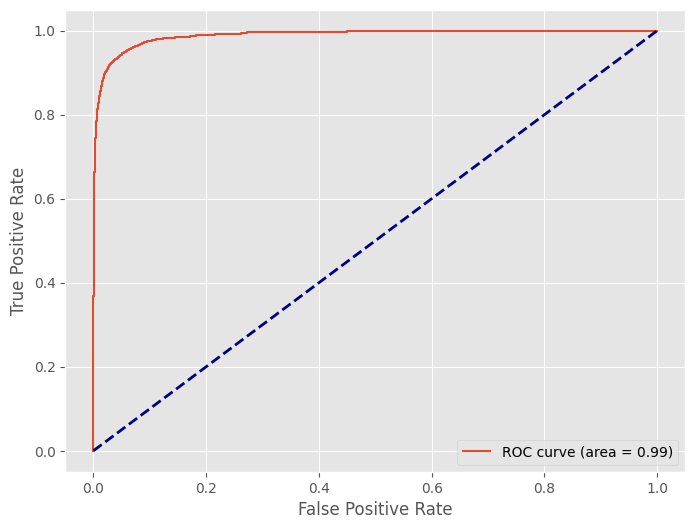

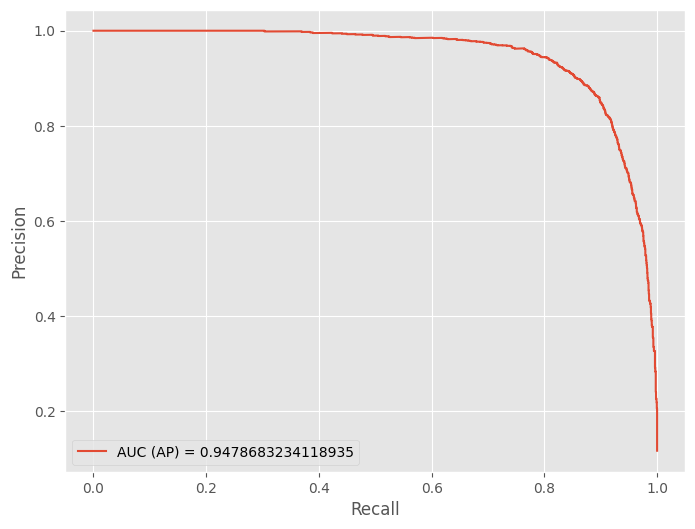

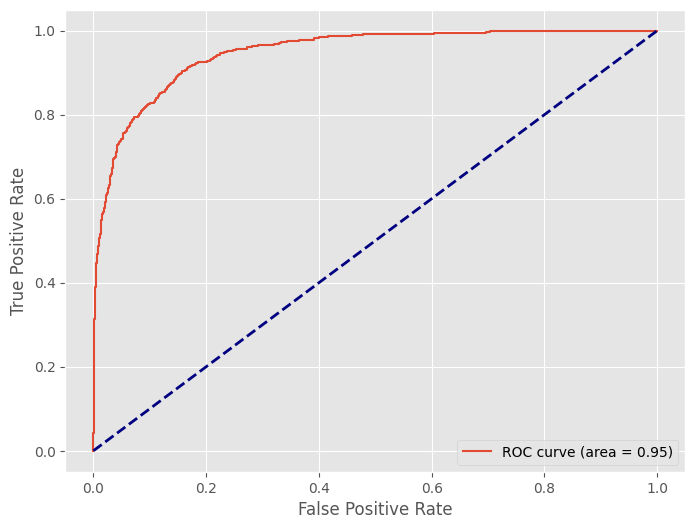

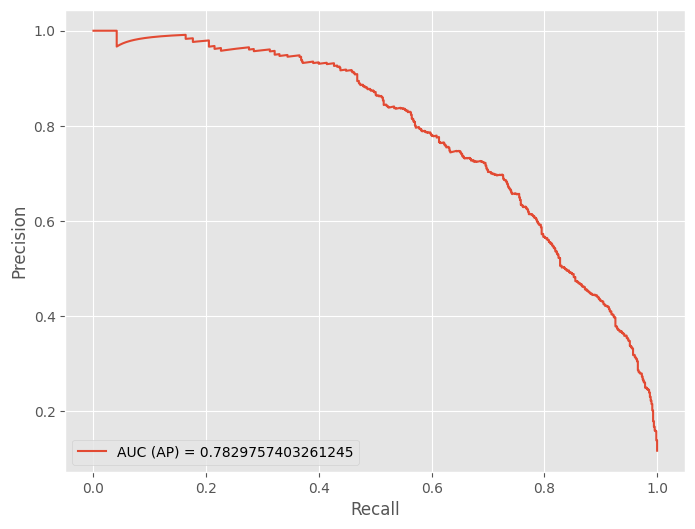

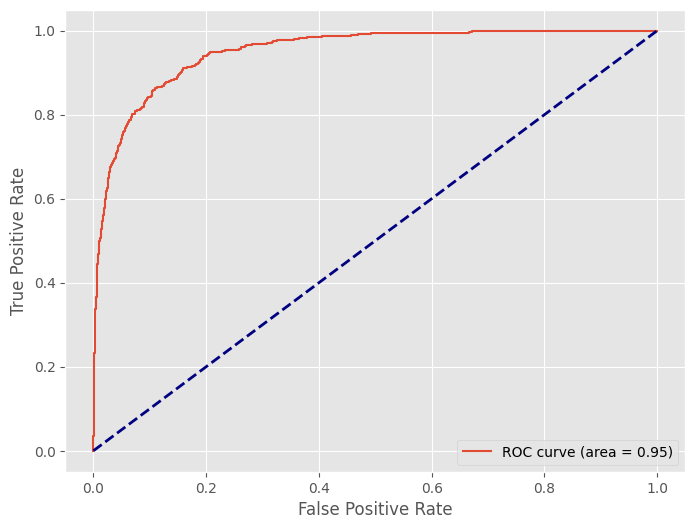

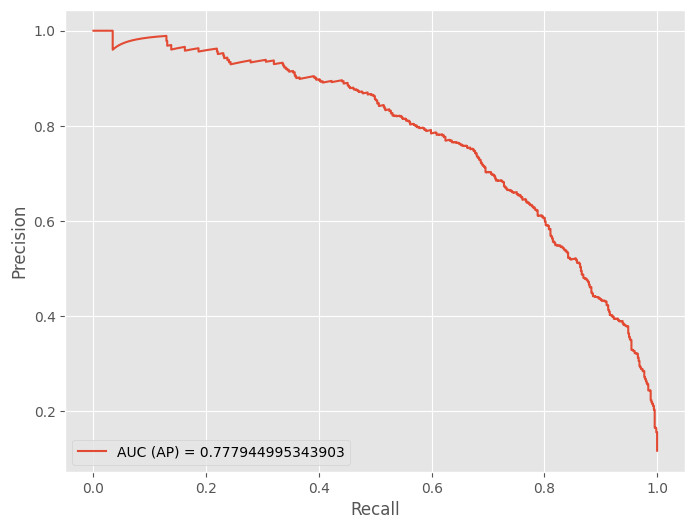

In [14]:
train_metrics, val_metrics, test_metrics = run_pipeline()

# Report

In [18]:
import base64
from io import BytesIO
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import logging

logger = logging.getLogger(__name__)

class ReportGenerator:
    def __init__(self, config):
        self.config = config
        self.html_content = ""

    def load_artifacts(self):
        """Загружает все необходимые артефакты из сохранённых файлов."""
        # Данные
        self.X_train = pd.read_csv(self.config.data_path + 'X_train.csv')
        self.y_train = pd.read_csv(self.config.data_path + 'y_train.csv').squeeze()
        self.X_val = pd.read_csv(self.config.data_path + 'X_val.csv')
        self.y_val = pd.read_csv(self.config.data_path + 'y_val.csv').squeeze()
        self.X_test = pd.read_csv(self.config.data_path + 'X_test.csv')
        self.y_test = pd.read_csv(self.config.data_path + 'y_test.csv').squeeze()

        # Отобранные признаки
        self.selected_features = joblib.load(self.config.features_path + 'selected_features.pkl')

        # Модель CatBoost
        self.model = joblib.load(self.config.models_path + 'catboost.pkl')

        # Метрики
        self.train_metrics = joblib.load(self.config.metrics_path + 'train_metrics.pkl')
        self.val_metrics = joblib.load(self.config.metrics_path + 'val_metrics.pkl')
        self.test_metrics = joblib.load(self.config.metrics_path + 'test_metrics.pkl')

        # Важность признаков
        try:
            self.feature_importance_df = pd.read_csv(self.config.features_path + 'catboost_feature_importance.csv')
        except FileNotFoundError:
            imp = self.model.get_feature_importance()
            self.feature_importance_df = pd.DataFrame({
                'feature': self.selected_features,
                'importance': imp
            }).sort_values('importance', ascending=False)
            self.feature_importance_df.to_csv(self.config.features_path + 'catboost_feature_importance.csv', index=False)

        # SHAP-значения
        try:
            shap_artifacts = joblib.load(self.config.models_path + 'shap_values_test.pkl')
            self.shap_values = shap_artifacts['shap_values']
            self.expected_value = shap_artifacts['expected_value']
            self.X_test_shap = shap_artifacts['data']
            self.feature_names = shap_artifacts.get('feature_names', self.selected_features)
        except FileNotFoundError:
            logger.warning("SHAP values not found, calculating now...")
            X_test_selected = self.X_test[self.selected_features]
            explainer = shap.TreeExplainer(self.model)
            shap_vals = explainer.shap_values(X_test_selected)
            # В бинарной классификации shap_values может быть списком (для классов 0 и 1)
            if isinstance(shap_vals, list):
                self.shap_values = shap_vals[1]      # берём значения для положительного класса
            else:
                self.shap_values = shap_vals
            self.expected_value = explainer.expected_value
            if isinstance(self.expected_value, list):
                self.expected_value = self.expected_value[1]  # для положительного класса
            self.X_test_shap = X_test_selected
            self.feature_names = self.selected_features
            # Сохраняем
            joblib.dump({
                'shap_values': self.shap_values,
                'expected_value': self.expected_value,
                'data': self.X_test_shap,
                'feature_names': self.feature_names
            }, self.config.models_path + 'shap_values_test.pkl')

    def _img_to_base64(self, fig):
        """Конвертирует matplotlib Figure в base64 строку."""
        buf = BytesIO()
        fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)
        img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
        buf.close()
        plt.close(fig)
        return img_base64

    def _plot_feature_importance(self, top_n=20):
        """Генерирует barplot важности признаков."""
        df = self.feature_importance_df.head(top_n)
        fig, ax = plt.subplots(figsize=(10, max(6, len(df)*0.3)))
        ax.barh(df['feature'], df['importance'], color='steelblue')
        ax.set_xlabel('Importance')
        ax.set_title(f'Top {top_n} Feature Importances (CatBoost)')
        ax.invert_yaxis()
        plt.tight_layout()
        return self._img_to_base64(fig)

    def _plot_beeswarm(self, max_display=15):
        """Генерирует beeswarm SHAP plot с использованием summary_plot (совместимо с массивами)."""
        # Используем shap.summary_plot, который принимает numpy массивы
        fig = plt.figure(figsize=(10, 8))
        shap.summary_plot(
            self.shap_values,
            self.X_test_shap,
            feature_names=self.feature_names,
            max_display=max_display,
            show=False
        )
        plt.tight_layout()
        return self._img_to_base64(fig)

    def _metrics_table(self):
        """Формирует HTML-таблицу с метриками для train/val/test."""
        metrics = ['roc_auc', 'average_precision']
        rows = []
        for split, split_metrics in zip(['Train', 'Validation', 'Test'],
                                        [self.train_metrics, self.val_metrics, self.test_metrics]):
            row = f"<tr><td>{split}</td>"
            for metric in metrics:
                row += f"<td>{split_metrics[metric]:.4f}</td>"
            report = split_metrics.get('classification_report', {})
            f1 = report.get('1', {}).get('f1-score', 0.0)
            row += f"<td>{f1:.4f}</td></tr>"
            rows.append(row)
        return f"""
        <table border="1" cellpadding="5" style="border-collapse: collapse; width: 100%;">
            <tr><th>Split</th><th>ROC-AUC</th><th>Average Precision</th><th>F1 (class 1)</th></tr>
            {''.join(rows)}
        </table>
        """

    def _embed_image(self, img_path):
        """Встраивает существующий PNG-файл как base64."""
        with open(img_path, 'rb') as f:
            img_data = f.read()
        return base64.b64encode(img_data).decode('utf-8')

    def generate(self, output_path='artifacts/report.html'):
        """Генерирует полный HTML-отчёт."""
        logger.info("Generating HTML report...")
        self.load_artifacts()

        # Генерация графиков
        fi_img_base64 = self._plot_feature_importance()
        beeswarm_img_base64 = self._plot_beeswarm()

        # Встраиваем ROC и PR кривые (должны быть сохранены пайплайном)
        train_roc = self._embed_image(self.config.img_path + 'train_roc_curve.png')
        train_pr = self._embed_image(self.config.img_path + 'train_pr_curve.png')
        val_roc = self._embed_image(self.config.img_path + 'val_roc_curve.png')
        val_pr = self._embed_image(self.config.img_path + 'val_pr_curve.png')
        test_roc = self._embed_image(self.config.img_path + 'test_roc_curve.png')
        test_pr = self._embed_image(self.config.img_path + 'test_pr_curve.png')

        # Сборка HTML
        html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <meta charset="utf-8">
            <title>Binary Classification Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f9f9f9; }}
                .container {{ background-color: white; padding: 30px; border-radius: 8px; box-shadow: 0 0 10px rgba(0,0,0,0.1); }}
                h1, h2, h3 {{ color: #333; }}
                table {{ width: 100%; margin-bottom: 20px; border-collapse: collapse; }}
                th {{ background-color: #4CAF50; color: white; padding: 12px; }}
                td {{ padding: 12px; border-bottom: 1px solid #ddd; }}
                tr:hover {{ background-color: #f5f5f5; }}
                img {{ max-width: 100%; height: auto; margin: 10px 0; border: 1px solid #ddd; }}
                .feature-list {{ columns: 3; -webkit-columns: 3; -moz-columns: 3; }}
                .feature-list li {{ break-inside: avoid; }}
            </style>
        </head>
        <body>
            <div class="container">
                <h1>📊 Отчёт по модели бинарной классификации</h1>
                <p><strong>Дата генерации:</strong> {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
                <p><strong>Целевая переменная:</strong> {self.config.target_column}</p>
                <p><strong>Метрика оптимизации:</strong> {self.config.metric_to_optimize}</p>
                <p><strong>Количество признаков:</strong> {len(self.selected_features)}</p>

                <h2>📈 Метрики качества</h2>
                {self._metrics_table()}

                <h2>🔍 Отобранные признаки</h2>
                <ul class="feature-list">
                    {''.join([f'<li>{feat}</li>' for feat in self.selected_features])}
                </ul>

                <h2>⭐ Важность признаков (CatBoost)</h2>
                <img src="data:image/png;base64,{fi_img_base64}" alt="Feature Importance">

                <h2>🐝 Beeswarm SHAP (на тестовой выборке)</h2>
                <img src="data:image/png;base64,{beeswarm_img_base64}" alt="Beeswarm SHAP">

                <h2>📉 Кривые ROC и Precision-Recall</h2>
                <h3>Train</h3>
                <img src="data:image/png;base64,{train_roc}" alt="Train ROC">
                <img src="data:image/png;base64,{train_pr}" alt="Train PR">
                <h3>Validation</h3>
                <img src="data:image/png;base64,{val_roc}" alt="Val ROC">
                <img src="data:image/png;base64,{val_pr}" alt="Val PR">
                <h3>Test</h3>
                <img src="data:image/png;base64,{test_roc}" alt="Test ROC">
                <img src="data:image/png;base64,{test_pr}" alt="Test PR">

                <h2>📋 Детальный classification report</h2>
                <p><em>Доступен в сохранённых метриках (см. артефакты).</em></p>
            </div>
        </body>
        </html>
        """

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(html)

        logger.info(f"Report saved to {output_path}")
        return output_path

In [19]:
report_gen = ReportGenerator(config)   # если вы перешли на Config
report_gen.generate('artifacts/final_report.html')

2026-02-11 16:04:39,933 - __main__ - INFO - Generating HTML report...
2026-02-11 16:04:40,881 - __main__ - INFO - Report saved to artifacts/final_report.html


'artifacts/final_report.html'